## Setup YOLO and Data For Training

In [1]:
! unzip -qq YOLOX.zip
! unzip -qq character-detection-datasets.zip

%cd YOLOX

/content/YOLOX


In [2]:
! pip install ninja
! pip install numpy
! pip install opencv_python
! pip install loguru
! pip install tqdm
! pip install thop
! pip install tabulate
! pip install psutil
! pip install tensorboard
! pip install pycocotools
! python setup.py build develop

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.9/422.9 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu1

## Import Libraries for Training and Testing

In [3]:
import os
from dataclasses import dataclass

from yolox.exp import Exp as MyExp


import argparse
import random
import warnings
from loguru import logger

import torch
import torch.backends.cudnn as cudnn

from yolox.exp import Exp, check_exp_value, get_exp
from yolox.utils import configure_module, configure_nccl, configure_omp, get_num_devices

from yolox.data.data_augment import ValTransform
import cv2
from yolox.utils import postprocess, vis
import time

import matplotlib.pyplot as plt

## Define Model and Training Config

In [4]:
class Exp(MyExp):
    def __init__(self):
        super(Exp, self).__init__()
        self.depth = 0.7
        self.width = 1.0
        self.exp_name = "Character-Detection"

        self.data_dir = "/content/character-detection-datasets"
        self.train_ann = "train.json"
        self.val_ann = "test.json"

        self.num_classes = 36

        self.max_epoch = 30
        self.eval_interval = 1
        self.data_num_workers = 4

@dataclass
class TrainingConfig:
    experiment_name: str = "CharacterDetection"
    batch_size: int = 8
    resume: bool = False
    ckpt: str = None
    start_epoch: int = 1
    num_machines: int = 1
    machine_rank: int = 0
    fp16: bool = False
    occupy: bool = False
    logger: str = 'tensorboard'
    output_dir = 'checkpoints/'
    cache: str = None

## Load Model and Train

In [5]:
args = TrainingConfig()
exp = Exp()
trainer = exp.get_trainer(args)
trainer.train()

/content/YOLOX/yolox/core/trainer.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=args.fp16)
2025-02-14 22:01:48 | INFO     | yolox.core.trainer:132 - args: TrainingConfig(experiment_name='CharacterDetection', batch_size=8, resume=False, ckpt=None, start_epoch=1, num_machines=1, machine_rank=0, fp16=False, occupy=False, logger='tensorboard', cache=None)
2025-02-14 22:01:48 | INFO     | yolox.core.trainer:133 - exp value:
╒═══════════════════╤═════════════════════════════════════════╕
│ keys              │ values                                  │
╞═══════════════════╪═════════════════════════════════════════╡
│ seed              │ None                                    │
├───────────────────┼─────────────────────────────────────────┤
│ output_dir        │ './YOLOX_outputs'                       │
├───────────────────┼──────────────────────────────────

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-02-14 22:01:50 | INFO     | yolox.core.trainer:157 - init prefetcher, this might take one minute or less...


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


2025-02-14 22:01:53 | INFO     | yolox.core.trainer:196 - Training start...
2025-02-14 22:01:53 | INFO     | yolox.core.trainer:197 - 
YOLOX(
  (backbone): YOLOPAFPN(
    (backbone): CSPDarknet(
      (stem): Focus(
        (conv): BaseConv(
          (conv): Conv2d(12, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
      )
      (dark2): Sequential(
        (0): BaseConv(
          (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (1): CSPLayer(
          (conv1): BaseConv(
            (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_runnin

Loading and preparing results...
DONE (t=4.17s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 4.01 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.84 seconds.


2025-02-14 22:07:24 | INFO     | yolox.core.trainer:381 - 
Average forward time: 33.02 ms, Average NMS time: 1.51 ms, Average inference time: 34.53 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

Loading and preparing results...
DONE (t=0.43s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.72 seconds.
Accumulating evaluation results...


2025-02-14 22:11:56 | INFO     | yolox.core.trainer:381 - 
Average forward time: 33.13 ms, Average NMS time: 0.98 ms, Average inference time: 34.11 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.009
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.014
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

COCOeval_opt.accumulate() finished in 0.24 seconds.


2025-02-14 22:11:59 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 22:12:00 | INFO     | yolox.core.trainer:218 - ---> start train epoch3
2025-02-14 22:12:10 | INFO     | yolox.core.trainer:270 - epoch: 3/30, iter: 10/257, gpu mem: 12089Mb, mem: 3.8Gb, iter_time: 0.988s, data_time: 0.003s, total_loss: 11.4, iou_loss: 3.3, l1_loss: 0.0, conf_loss: 5.3, cls_loss: 2.9, lr: 2.079e-04, size: 800, ETA: 1:57:26
2025-02-14 22:12:26 | INFO     | yolox.core.trainer:270 - epoch: 3/30, iter: 20/257, gpu mem: 12089Mb, mem: 3.9Gb, iter_time: 1.539s, data_time: 0.003s, total_loss: 11.1, iou_loss: 3.3, l1_loss: 0.0, conf_loss: 5.0, cls_loss: 2.8, lr: 2.159e-04, size: 800, ETA: 1:58:31
2025-02-14 22:12:40 | INFO     | yolox.core.trainer:270 - epoch: 3/30, iter: 30/257, gpu mem: 12089Mb, mem: 3.9Gb, iter_time: 1.434s, data_time: 0.002s, total_loss: 10.5, iou_loss: 3.1, l1_loss: 0.0, conf_loss: 4.5, cls_loss: 2.8, lr: 2.240e-04, size: 704, ETA: 1:59:20

Loading and preparing results...
DONE (t=1.55s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 1.55 seconds.
Accumulating evaluation results...


2025-02-14 22:17:02 | INFO     | yolox.core.trainer:381 - 
Average forward time: 32.72 ms, Average NMS time: 1.03 ms, Average inference time: 33.75 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.036
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.023
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.015
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.024
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.039
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.086
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.104
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.083
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

COCOeval_opt.accumulate() finished in 0.52 seconds.


2025-02-14 22:17:09 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 22:17:10 | INFO     | yolox.core.trainer:218 - ---> start train epoch4
2025-02-14 22:17:18 | INFO     | yolox.core.trainer:270 - epoch: 4/30, iter: 10/257, gpu mem: 12089Mb, mem: 3.9Gb, iter_time: 0.808s, data_time: 0.002s, total_loss: 8.2, iou_loss: 2.4, l1_loss: 0.0, conf_loss: 3.0, cls_loss: 2.7, lr: 4.617e-04, size: 640, ETA: 1:54:31
2025-02-14 22:17:28 | INFO     | yolox.core.trainer:270 - epoch: 4/30, iter: 20/257, gpu mem: 12089Mb, mem: 3.9Gb, iter_time: 0.983s, data_time: 0.003s, total_loss: 8.6, iou_loss: 2.8, l1_loss: 0.0, conf_loss: 3.2, cls_loss: 2.6, lr: 4.736e-04, size: 544, ETA: 1:54:20
2025-02-14 22:17:36 | INFO     | yolox.core.trainer:270 - epoch: 4/30, iter: 30/257, gpu mem: 12089Mb, mem: 3.9Gb, iter_time: 0.854s, data_time: 0.002s, total_loss: 8.6, iou_loss: 2.7, l1_loss: 0.0, conf_loss: 3.3, cls_loss: 2.7, lr: 4.857e-04, size: 704, ETA: 1:53:58
20

Loading and preparing results...
DONE (t=0.53s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.63 seconds.
Accumulating evaluation results...


2025-02-14 22:21:56 | INFO     | yolox.core.trainer:381 - 
Average forward time: 33.04 ms, Average NMS time: 0.98 ms, Average inference time: 34.03 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.236
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.455
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.209
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.198
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.247
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.259
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.332
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.398
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.398
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.338
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

COCOeval_opt.accumulate() finished in 0.20 seconds.


2025-02-14 22:21:59 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 22:22:01 | INFO     | yolox.core.trainer:218 - ---> start train epoch5
2025-02-14 22:22:11 | INFO     | yolox.core.trainer:270 - epoch: 5/30, iter: 10/257, gpu mem: 12089Mb, mem: 3.8Gb, iter_time: 0.960s, data_time: 0.003s, total_loss: 6.2, iou_loss: 2.3, l1_loss: 0.0, conf_loss: 2.1, cls_loss: 1.9, lr: 8.156e-04, size: 576, ETA: 1:50:31
2025-02-14 22:22:19 | INFO     | yolox.core.trainer:270 - epoch: 5/30, iter: 20/257, gpu mem: 12089Mb, mem: 3.7Gb, iter_time: 0.857s, data_time: 0.003s, total_loss: 7.1, iou_loss: 2.6, l1_loss: 0.0, conf_loss: 2.6, cls_loss: 1.9, lr: 8.314e-04, size: 576, ETA: 1:50:12
2025-02-14 22:22:32 | INFO     | yolox.core.trainer:270 - epoch: 5/30, iter: 30/257, gpu mem: 12089Mb, mem: 3.8Gb, iter_time: 1.242s, data_time: 0.003s, total_loss: 6.7, iou_loss: 2.5, l1_loss: 0.0, conf_loss: 2.2, cls_loss: 2.0, lr: 8.474e-04, size: 736, ETA: 1:50:18
20

Loading and preparing results...
DONE (t=0.82s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 1.31 seconds.
Accumulating evaluation results...


2025-02-14 22:26:59 | INFO     | yolox.core.trainer:381 - 
Average forward time: 32.83 ms, Average NMS time: 1.06 ms, Average inference time: 33.88 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.390
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.684
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.401
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.306
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.400
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.426
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.462
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.524
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.525
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.400
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

COCOeval_opt.accumulate() finished in 0.28 seconds.


2025-02-14 22:27:03 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 22:27:04 | INFO     | yolox.core.trainer:218 - ---> start train epoch6
2025-02-14 22:27:17 | INFO     | yolox.core.trainer:270 - epoch: 6/30, iter: 10/257, gpu mem: 12089Mb, mem: 3.8Gb, iter_time: 1.234s, data_time: 0.002s, total_loss: 6.7, iou_loss: 2.3, l1_loss: 0.0, conf_loss: 2.6, cls_loss: 1.8, lr: 1.250e-03, size: 800, ETA: 1:47:18
2025-02-14 22:27:31 | INFO     | yolox.core.trainer:270 - epoch: 6/30, iter: 20/257, gpu mem: 12089Mb, mem: 3.7Gb, iter_time: 1.381s, data_time: 0.003s, total_loss: 4.8, iou_loss: 1.8, l1_loss: 0.0, conf_loss: 1.6, cls_loss: 1.3, lr: 1.250e-03, size: 672, ETA: 1:47:26
2025-02-14 22:27:44 | INFO     | yolox.core.trainer:270 - epoch: 6/30, iter: 30/257, gpu mem: 12089Mb, mem: 3.8Gb, iter_time: 1.357s, data_time: 0.002s, total_loss: 4.9, iou_loss: 1.9, l1_loss: 0.0, conf_loss: 1.6, cls_loss: 1.4, lr: 1.250e-03, size: 800, ETA: 1:47:33
20

Loading and preparing results...
DONE (t=0.15s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 22:32:18 | INFO     | yolox.core.trainer:381 - 
Average forward time: 33.37 ms, Average NMS time: 0.94 ms, Average inference time: 34.32 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.485
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.786
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.549
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.359
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.495
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.521
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.526
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.578
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.579
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.457
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

COCOeval_opt.evaluate() finished in 0.50 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.14 seconds.


2025-02-14 22:32:20 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 22:32:22 | INFO     | yolox.core.trainer:218 - ---> start train epoch7
2025-02-14 22:32:31 | INFO     | yolox.core.trainer:270 - epoch: 7/30, iter: 10/257, gpu mem: 12089Mb, mem: 3.7Gb, iter_time: 0.984s, data_time: 0.002s, total_loss: 5.4, iou_loss: 2.1, l1_loss: 0.0, conf_loss: 1.7, cls_loss: 1.6, lr: 1.219e-03, size: 544, ETA: 1:44:25
2025-02-14 22:32:39 | INFO     | yolox.core.trainer:270 - epoch: 7/30, iter: 20/257, gpu mem: 12089Mb, mem: 3.7Gb, iter_time: 0.755s, data_time: 0.002s, total_loss: 3.9, iou_loss: 1.8, l1_loss: 0.0, conf_loss: 1.0, cls_loss: 1.1, lr: 1.216e-03, size: 480, ETA: 1:44:05
2025-02-14 22:32:46 | INFO     | yolox.core.trainer:270 - epoch: 7/30, iter: 30/257, gpu mem: 12089Mb, mem: 3.7Gb, iter_time: 0.686s, data_time: 0.003s, total_loss: 4.3, iou_loss: 1.8, l1_loss: 0.0, conf_loss: 1.2, cls_loss: 1.3, lr: 1.214e-03, size: 576, ETA: 1:43:42
20

Loading and preparing results...
DONE (t=0.43s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 22:36:51 | INFO     | yolox.core.trainer:381 - 
Average forward time: 33.78 ms, Average NMS time: 0.93 ms, Average inference time: 34.71 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.511
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.856
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.555
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.364
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.526
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.529
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.539
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.590
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.590
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.482
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

COCOeval_opt.evaluate() finished in 0.43 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.13 seconds.


2025-02-14 22:36:58 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 22:36:59 | INFO     | yolox.core.trainer:218 - ---> start train epoch8
2025-02-14 22:37:08 | INFO     | yolox.core.trainer:270 - epoch: 8/30, iter: 10/257, gpu mem: 12089Mb, mem: 3.7Gb, iter_time: 0.898s, data_time: 0.003s, total_loss: 4.6, iou_loss: 1.9, l1_loss: 0.0, conf_loss: 1.5, cls_loss: 1.3, lr: 1.132e-03, size: 608, ETA: 1:39:16
2025-02-14 22:37:21 | INFO     | yolox.core.trainer:270 - epoch: 8/30, iter: 20/257, gpu mem: 12089Mb, mem: 3.7Gb, iter_time: 1.283s, data_time: 0.002s, total_loss: 4.6, iou_loss: 1.9, l1_loss: 0.0, conf_loss: 1.4, cls_loss: 1.2, lr: 1.128e-03, size: 736, ETA: 1:39:14
2025-02-14 22:37:29 | INFO     | yolox.core.trainer:270 - epoch: 8/30, iter: 30/257, gpu mem: 12089Mb, mem: 3.7Gb, iter_time: 0.736s, data_time: 0.002s, total_loss: 4.9, iou_loss: 2.1, l1_loss: 0.0, conf_loss: 1.6, cls_loss: 1.2, lr: 1.123e-03, size: 512, ETA: 1:38:55
20

Loading and preparing results...
DONE (t=0.51s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.49 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.16 seconds.


2025-02-14 22:41:26 | INFO     | yolox.core.trainer:381 - 
Average forward time: 33.42 ms, Average NMS time: 0.98 ms, Average inference time: 34.40 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.543
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.820
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.656
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.345
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.554
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.592
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.567
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.620
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.620
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.454
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 22:46:21 | INFO     | yolox.core.trainer:381 - 
Average forward time: 33.87 ms, Average NMS time: 1.01 ms, Average inference time: 34.88 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.634
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.952
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.771
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.552
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.647
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.665
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.638
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.688
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.688
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.596
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

COCOeval_opt.evaluate() finished in 0.27 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.11 seconds.


2025-02-14 22:46:28 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 22:46:29 | INFO     | yolox.core.trainer:218 - ---> start train epoch10
2025-02-14 22:46:40 | INFO     | yolox.core.trainer:270 - epoch: 10/30, iter: 10/257, gpu mem: 12089Mb, mem: 3.8Gb, iter_time: 1.096s, data_time: 0.002s, total_loss: 3.4, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 1.1, cls_loss: 0.8, lr: 8.328e-04, size: 768, ETA: 1:30:17
2025-02-14 22:46:52 | INFO     | yolox.core.trainer:270 - epoch: 10/30, iter: 20/257, gpu mem: 12089Mb, mem: 3.7Gb, iter_time: 1.250s, data_time: 0.002s, total_loss: 4.0, iou_loss: 1.7, l1_loss: 0.0, conf_loss: 1.3, cls_loss: 1.0, lr: 8.259e-04, size: 608, ETA: 1:30:13
2025-02-14 22:47:03 | INFO     | yolox.core.trainer:270 - epoch: 10/30, iter: 30/257, gpu mem: 12089Mb, mem: 3.8Gb, iter_time: 1.022s, data_time: 0.003s, total_loss: 3.6, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 1.2, cls_loss: 0.9, lr: 8.189e-04, size: 672, ETA: 1:30:0

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 22:51:22 | INFO     | yolox.core.trainer:381 - 
Average forward time: 33.75 ms, Average NMS time: 0.94 ms, Average inference time: 34.69 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.682
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.964
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.852
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.567
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.688
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.716
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.683
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.736
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.736
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.620
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

COCOeval_opt.evaluate() finished in 0.29 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.11 seconds.


2025-02-14 22:51:28 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 22:51:29 | INFO     | yolox.core.trainer:218 - ---> start train epoch11
2025-02-14 22:51:37 | INFO     | yolox.core.trainer:270 - epoch: 11/30, iter: 10/257, gpu mem: 12089Mb, mem: 3.7Gb, iter_time: 0.802s, data_time: 0.004s, total_loss: 3.3, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 0.9, cls_loss: 0.9, lr: 6.490e-04, size: 544, ETA: 1:26:10
2025-02-14 22:51:46 | INFO     | yolox.core.trainer:270 - epoch: 11/30, iter: 20/257, gpu mem: 12089Mb, mem: 3.7Gb, iter_time: 0.829s, data_time: 0.003s, total_loss: 4.0, iou_loss: 1.7, l1_loss: 0.0, conf_loss: 1.2, cls_loss: 1.1, lr: 6.417e-04, size: 576, ETA: 1:25:56
2025-02-14 22:52:01 | INFO     | yolox.core.trainer:270 - epoch: 11/30, iter: 30/257, gpu mem: 12089Mb, mem: 3.7Gb, iter_time: 1.573s, data_time: 0.005s, total_loss: 3.2, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 1.1, cls_loss: 0.8, lr: 6.345e-04, size: 800, ETA: 1:25:5

Loading and preparing results...
DONE (t=0.30s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 1.08 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.19 seconds.


2025-02-14 22:56:23 | INFO     | yolox.core.trainer:381 - 
Average forward time: 33.13 ms, Average NMS time: 0.93 ms, Average inference time: 34.06 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.650
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.952
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.804
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.487
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.657
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.697
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.654
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.705
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.706
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.545
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 23:01:24 | INFO     | yolox.core.trainer:381 - 
Average forward time: 33.77 ms, Average NMS time: 0.99 ms, Average inference time: 34.76 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.693
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.970
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.869
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.603
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.697
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.724
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.692
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.745
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.745
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.662
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

COCOeval_opt.evaluate() finished in 0.29 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.11 seconds.


2025-02-14 23:01:35 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 23:01:36 | INFO     | yolox.core.trainer:218 - ---> start train epoch13
2025-02-14 23:01:47 | INFO     | yolox.core.trainer:270 - epoch: 13/30, iter: 10/257, gpu mem: 12097Mb, mem: 3.7Gb, iter_time: 1.067s, data_time: 0.004s, total_loss: 4.1, iou_loss: 1.7, l1_loss: 0.0, conf_loss: 1.3, cls_loss: 1.1, lr: 3.014e-04, size: 512, ETA: 1:17:54
2025-02-14 23:01:55 | INFO     | yolox.core.trainer:270 - epoch: 13/30, iter: 20/257, gpu mem: 12097Mb, mem: 3.7Gb, iter_time: 0.803s, data_time: 0.002s, total_loss: 3.1, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.9, cls_loss: 0.8, lr: 2.956e-04, size: 640, ETA: 1:17:41
2025-02-14 23:02:06 | INFO     | yolox.core.trainer:270 - epoch: 13/30, iter: 30/257, gpu mem: 12097Mb, mem: 3.7Gb, iter_time: 1.157s, data_time: 0.002s, total_loss: 3.5, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 1.0, cls_loss: 0.9, lr: 2.899e-04, size: 736, ETA: 1:17:3

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 23:06:40 | INFO     | yolox.core.trainer:381 - 
Average forward time: 33.94 ms, Average NMS time: 0.94 ms, Average inference time: 34.88 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.695
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.973
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.864
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.580
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.702
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.720
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.692
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.745
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.745
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.635
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

COCOeval_opt.evaluate() finished in 0.62 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 23:06:49 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 23:06:51 | INFO     | yolox.core.trainer:218 - ---> start train epoch14
2025-02-14 23:06:58 | INFO     | yolox.core.trainer:270 - epoch: 14/30, iter: 10/257, gpu mem: 12097Mb, mem: 3.8Gb, iter_time: 0.678s, data_time: 0.004s, total_loss: 4.6, iou_loss: 1.8, l1_loss: 0.0, conf_loss: 1.5, cls_loss: 1.3, lr: 1.717e-04, size: 736, ETA: 1:13:57
2025-02-14 23:07:11 | INFO     | yolox.core.trainer:270 - epoch: 14/30, iter: 20/257, gpu mem: 12097Mb, mem: 3.8Gb, iter_time: 1.312s, data_time: 0.002s, total_loss: 3.2, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 1.0, cls_loss: 0.7, lr: 1.675e-04, size: 704, ETA: 1:13:51
2025-02-14 23:07:23 | INFO     | yolox.core.trainer:270 - epoch: 14/30, iter: 30/257, gpu mem: 12097Mb, mem: 3.7Gb, iter_time: 1.217s, data_time: 0.003s, total_loss: 3.0, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.9, cls_loss: 0.7, lr: 1.634e-04, size: 640, ETA: 1:13:4

Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 23:12:04 | INFO     | yolox.core.trainer:381 - 
Average forward time: 33.60 ms, Average NMS time: 0.90 ms, Average inference time: 34.50 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.710
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.970
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.898
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.592
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.717
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.739
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.706
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.759
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.759
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.640
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

COCOeval_opt.evaluate() finished in 0.30 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.11 seconds.


2025-02-14 23:12:07 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 23:12:08 | INFO     | yolox.core.trainer:218 - ---> start train epoch15
2025-02-14 23:12:08 | INFO     | yolox.core.trainer:221 - --->No mosaic aug now!
2025-02-14 23:12:08 | INFO     | yolox.core.trainer:223 - --->Add additional L1 loss now!
2025-02-14 23:12:08 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 23:12:23 | INFO     | yolox.core.trainer:270 - epoch: 15/30, iter: 10/257, gpu mem: 12097Mb, mem: 3.6Gb, iter_time: 1.288s, data_time: 0.003s, total_loss: 3.7, iou_loss: 1.4, l1_loss: 0.7, conf_loss: 1.1, cls_loss: 0.6, lr: 8.936e-05, size: 768, ETA: 1:10:10
2025-02-14 23:12:33 | INFO     | yolox.core.trainer:270 - epoch: 15/30, iter: 20/257, gpu mem: 12097Mb, mem: 3.6Gb, iter_time: 1.054s, data_time: 0.002s, total_loss: 2.9, iou_loss: 1.1, l1_loss: 0.5, conf_loss: 0.8, cls_loss: 0.4, lr: 8.724e-05, size: 640, E

Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.38 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.17 seconds.


2025-02-14 23:17:05 | INFO     | yolox.core.trainer:381 - 
Average forward time: 33.90 ms, Average NMS time: 0.92 ms, Average inference time: 34.82 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.714
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.980
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.898
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.637
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.717
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.742
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.707
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.761
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.761
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.670
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 23:22:19 | INFO     | yolox.core.trainer:381 - 
Average forward time: 33.73 ms, Average NMS time: 1.13 ms, Average inference time: 34.86 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.736
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.985
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.929
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.639
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.740
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.766
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.725
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.688
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

COCOeval_opt.evaluate() finished in 0.24 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 23:22:21 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 23:22:23 | INFO     | yolox.core.trainer:218 - ---> start train epoch17
2025-02-14 23:22:30 | INFO     | yolox.core.trainer:270 - epoch: 17/30, iter: 10/257, gpu mem: 12097Mb, mem: 3.6Gb, iter_time: 0.734s, data_time: 0.003s, total_loss: 3.4, iou_loss: 1.5, l1_loss: 0.6, conf_loss: 0.7, cls_loss: 0.6, lr: 6.250e-05, size: 512, ETA: 1:01:39
2025-02-14 23:22:37 | INFO     | yolox.core.trainer:270 - epoch: 17/30, iter: 20/257, gpu mem: 12097Mb, mem: 3.6Gb, iter_time: 0.708s, data_time: 0.002s, total_loss: 3.1, iou_loss: 1.2, l1_loss: 0.5, conf_loss: 0.9, cls_loss: 0.4, lr: 6.250e-05, size: 672, ETA: 1:01:26
2025-02-14 23:22:48 | INFO     | yolox.core.trainer:270 - epoch: 17/30, iter: 30/257, gpu mem: 12097Mb, mem: 3.6Gb, iter_time: 1.107s, data_time: 0.004s, total_loss: 2.7, iou_loss: 1.1, l1_loss: 0.5, conf_loss: 0.7, cls_loss: 0.4, lr: 6.250e-05, size: 672, ETA: 1:01:1

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 1.31 seconds.
Accumulating evaluation results...


2025-02-14 23:26:44 | INFO     | yolox.core.trainer:381 - 
Average forward time: 33.76 ms, Average NMS time: 1.01 ms, Average inference time: 34.77 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.738
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.983
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.922
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.643
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.743
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.766
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.728
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.784
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.784
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.679
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

COCOeval_opt.accumulate() finished in 0.35 seconds.


2025-02-14 23:26:46 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 23:26:48 | INFO     | yolox.core.trainer:218 - ---> start train epoch18
2025-02-14 23:26:54 | INFO     | yolox.core.trainer:270 - epoch: 18/30, iter: 10/257, gpu mem: 12097Mb, mem: 3.6Gb, iter_time: 0.625s, data_time: 0.003s, total_loss: 2.8, iou_loss: 1.2, l1_loss: 0.5, conf_loss: 0.6, cls_loss: 0.5, lr: 6.250e-05, size: 512, ETA: 0:56:52
2025-02-14 23:27:07 | INFO     | yolox.core.trainer:270 - epoch: 18/30, iter: 20/257, gpu mem: 12097Mb, mem: 3.6Gb, iter_time: 1.245s, data_time: 0.002s, total_loss: 3.2, iou_loss: 1.2, l1_loss: 0.7, conf_loss: 0.9, cls_loss: 0.5, lr: 6.250e-05, size: 768, ETA: 0:56:43
2025-02-14 23:27:15 | INFO     | yolox.core.trainer:270 - epoch: 18/30, iter: 30/257, gpu mem: 12097Mb, mem: 3.6Gb, iter_time: 0.827s, data_time: 0.004s, total_loss: 2.7, iou_loss: 1.2, l1_loss: 0.5, conf_loss: 0.6, cls_loss: 0.4, lr: 6.250e-05, size: 544, ETA: 0:56:3

Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 1.26 seconds.
Accumulating evaluation results...


2025-02-14 23:31:21 | INFO     | yolox.core.trainer:381 - 
Average forward time: 33.67 ms, Average NMS time: 0.96 ms, Average inference time: 34.63 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.740
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.984
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.918
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.653
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.745
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.768
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.730
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.785
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.785
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.692
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

COCOeval_opt.accumulate() finished in 0.29 seconds.


2025-02-14 23:31:23 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 23:31:25 | INFO     | yolox.core.trainer:218 - ---> start train epoch19
2025-02-14 23:31:34 | INFO     | yolox.core.trainer:270 - epoch: 19/30, iter: 10/257, gpu mem: 12097Mb, mem: 3.6Gb, iter_time: 0.882s, data_time: 0.002s, total_loss: 2.6, iou_loss: 1.1, l1_loss: 0.4, conf_loss: 0.6, cls_loss: 0.4, lr: 6.250e-05, size: 640, ETA: 0:52:18
2025-02-14 23:31:45 | INFO     | yolox.core.trainer:270 - epoch: 19/30, iter: 20/257, gpu mem: 12097Mb, mem: 3.6Gb, iter_time: 1.100s, data_time: 0.003s, total_loss: 2.5, iou_loss: 1.0, l1_loss: 0.4, conf_loss: 0.8, cls_loss: 0.4, lr: 6.250e-05, size: 704, ETA: 0:52:09
2025-02-14 23:31:57 | INFO     | yolox.core.trainer:270 - epoch: 19/30, iter: 30/257, gpu mem: 12097Mb, mem: 3.6Gb, iter_time: 1.258s, data_time: 0.003s, total_loss: 3.7, iou_loss: 1.2, l1_loss: 0.7, conf_loss: 1.1, cls_loss: 0.6, lr: 6.250e-05, size: 736, ETA: 0:52:0

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 23:36:16 | INFO     | yolox.core.trainer:381 - 
Average forward time: 33.76 ms, Average NMS time: 1.14 ms, Average inference time: 34.90 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.743
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.987
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.937
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.647
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.746
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.774
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.732
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.788
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.788
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.691
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

COCOeval_opt.evaluate() finished in 0.27 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 23:36:23 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 23:36:24 | INFO     | yolox.core.trainer:218 - ---> start train epoch20
2025-02-14 23:36:31 | INFO     | yolox.core.trainer:270 - epoch: 20/30, iter: 10/257, gpu mem: 12097Mb, mem: 3.6Gb, iter_time: 0.734s, data_time: 0.003s, total_loss: 3.0, iou_loss: 1.5, l1_loss: 0.5, conf_loss: 0.5, cls_loss: 0.5, lr: 6.250e-05, size: 480, ETA: 0:47:56
2025-02-14 23:36:39 | INFO     | yolox.core.trainer:270 - epoch: 20/30, iter: 20/257, gpu mem: 12097Mb, mem: 3.6Gb, iter_time: 0.731s, data_time: 0.002s, total_loss: 3.5, iou_loss: 1.3, l1_loss: 0.6, conf_loss: 0.9, cls_loss: 0.6, lr: 6.250e-05, size: 672, ETA: 0:47:44
2025-02-14 23:36:51 | INFO     | yolox.core.trainer:270 - epoch: 20/30, iter: 30/257, gpu mem: 12097Mb, mem: 3.6Gb, iter_time: 1.192s, data_time: 0.004s, total_loss: 2.9, iou_loss: 1.1, l1_loss: 0.6, conf_loss: 0.8, cls_loss: 0.4, lr: 6.250e-05, size: 768, ETA: 0:47:3

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 23:41:14 | INFO     | yolox.core.trainer:381 - 
Average forward time: 33.73 ms, Average NMS time: 1.05 ms, Average inference time: 34.78 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.747
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.987
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.943
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.666
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.748
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.775
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.735
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.790
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.790
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.702
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

COCOeval_opt.evaluate() finished in 0.23 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.09 seconds.


2025-02-14 23:41:20 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 23:41:21 | INFO     | yolox.core.trainer:218 - ---> start train epoch21
2025-02-14 23:41:29 | INFO     | yolox.core.trainer:270 - epoch: 21/30, iter: 10/257, gpu mem: 12097Mb, mem: 3.6Gb, iter_time: 0.819s, data_time: 0.002s, total_loss: 3.0, iou_loss: 1.3, l1_loss: 0.5, conf_loss: 0.7, cls_loss: 0.6, lr: 6.250e-05, size: 576, ETA: 0:43:35
2025-02-14 23:41:40 | INFO     | yolox.core.trainer:270 - epoch: 21/30, iter: 20/257, gpu mem: 12097Mb, mem: 3.6Gb, iter_time: 1.107s, data_time: 0.002s, total_loss: 2.6, iou_loss: 1.0, l1_loss: 0.5, conf_loss: 0.7, cls_loss: 0.4, lr: 6.250e-05, size: 672, ETA: 0:43:25
2025-02-14 23:41:53 | INFO     | yolox.core.trainer:270 - epoch: 21/30, iter: 30/257, gpu mem: 12097Mb, mem: 3.6Gb, iter_time: 1.309s, data_time: 0.002s, total_loss: 2.6, iou_loss: 1.0, l1_loss: 0.5, conf_loss: 0.6, cls_loss: 0.4, lr: 6.250e-05, size: 736, ETA: 0:43:1

Loading and preparing results...
DONE (t=0.46s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 23:45:54 | INFO     | yolox.core.trainer:381 - 
Average forward time: 33.74 ms, Average NMS time: 1.05 ms, Average inference time: 34.80 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.748
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.986
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.944
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.666
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.750
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.777
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.735
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.791
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.791
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.700
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

COCOeval_opt.evaluate() finished in 0.23 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.11 seconds.


2025-02-14 23:45:57 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 23:45:58 | INFO     | yolox.core.trainer:218 - ---> start train epoch22
2025-02-14 23:46:13 | INFO     | yolox.core.trainer:270 - epoch: 22/30, iter: 10/257, gpu mem: 12103Mb, mem: 3.6Gb, iter_time: 1.421s, data_time: 0.003s, total_loss: 3.6, iou_loss: 1.4, l1_loss: 0.7, conf_loss: 0.9, cls_loss: 0.6, lr: 6.250e-05, size: 800, ETA: 0:39:08
2025-02-14 23:46:28 | INFO     | yolox.core.trainer:270 - epoch: 22/30, iter: 20/257, gpu mem: 12103Mb, mem: 3.6Gb, iter_time: 1.538s, data_time: 0.003s, total_loss: 3.4, iou_loss: 1.1, l1_loss: 0.7, conf_loss: 1.1, cls_loss: 0.5, lr: 6.250e-05, size: 800, ETA: 0:39:00
2025-02-14 23:46:43 | INFO     | yolox.core.trainer:270 - epoch: 22/30, iter: 30/257, gpu mem: 12103Mb, mem: 3.6Gb, iter_time: 1.529s, data_time: 0.003s, total_loss: 3.6, iou_loss: 1.2, l1_loss: 0.6, conf_loss: 1.0, cls_loss: 0.7, lr: 6.250e-05, size: 800, ETA: 0:38:5

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 23:50:44 | INFO     | yolox.core.trainer:381 - 
Average forward time: 33.94 ms, Average NMS time: 0.90 ms, Average inference time: 34.84 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.745
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.987
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.922
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.652
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.750
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.773
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.734
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.790
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.790
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.695
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

COCOeval_opt.evaluate() finished in 0.25 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 23:50:45 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 23:50:46 | INFO     | yolox.core.trainer:218 - ---> start train epoch23
2025-02-14 23:50:54 | INFO     | yolox.core.trainer:270 - epoch: 23/30, iter: 10/257, gpu mem: 12103Mb, mem: 3.6Gb, iter_time: 0.739s, data_time: 0.002s, total_loss: 2.6, iou_loss: 1.1, l1_loss: 0.5, conf_loss: 0.6, cls_loss: 0.4, lr: 6.250e-05, size: 640, ETA: 0:34:44
2025-02-14 23:51:05 | INFO     | yolox.core.trainer:270 - epoch: 23/30, iter: 20/257, gpu mem: 12103Mb, mem: 3.6Gb, iter_time: 1.061s, data_time: 0.002s, total_loss: 2.6, iou_loss: 1.0, l1_loss: 0.5, conf_loss: 0.7, cls_loss: 0.4, lr: 6.250e-05, size: 704, ETA: 0:34:34
2025-02-14 23:51:18 | INFO     | yolox.core.trainer:270 - epoch: 23/30, iter: 30/257, gpu mem: 12103Mb, mem: 3.6Gb, iter_time: 1.309s, data_time: 0.003s, total_loss: 3.3, iou_loss: 1.2, l1_loss: 0.6, conf_loss: 0.9, cls_loss: 0.6, lr: 6.250e-05, size: 800, ETA: 0:34:2

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 23:55:25 | INFO     | yolox.core.trainer:381 - 
Average forward time: 33.89 ms, Average NMS time: 0.93 ms, Average inference time: 34.82 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.749
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.987
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.943
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.673
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.751
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.780
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.737
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.794
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.794
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.706
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

COCOeval_opt.evaluate() finished in 0.59 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.11 seconds.


2025-02-14 23:55:28 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 23:55:29 | INFO     | yolox.core.trainer:218 - ---> start train epoch24
2025-02-14 23:55:36 | INFO     | yolox.core.trainer:270 - epoch: 24/30, iter: 10/257, gpu mem: 12103Mb, mem: 3.6Gb, iter_time: 0.650s, data_time: 0.002s, total_loss: 2.9, iou_loss: 1.3, l1_loss: 0.5, conf_loss: 0.6, cls_loss: 0.5, lr: 6.250e-05, size: 672, ETA: 0:30:20
2025-02-14 23:55:47 | INFO     | yolox.core.trainer:270 - epoch: 24/30, iter: 20/257, gpu mem: 12103Mb, mem: 3.6Gb, iter_time: 1.072s, data_time: 0.002s, total_loss: 2.3, iou_loss: 1.0, l1_loss: 0.4, conf_loss: 0.6, cls_loss: 0.4, lr: 6.250e-05, size: 544, ETA: 0:30:10
2025-02-14 23:55:55 | INFO     | yolox.core.trainer:270 - epoch: 24/30, iter: 30/257, gpu mem: 12103Mb, mem: 3.6Gb, iter_time: 0.810s, data_time: 0.003s, total_loss: 3.0, iou_loss: 1.0, l1_loss: 0.5, conf_loss: 1.1, cls_loss: 0.4, lr: 6.250e-05, size: 736, ETA: 0:29:5

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 1.74 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.15 seconds.


2025-02-15 00:00:03 | INFO     | yolox.core.trainer:381 - 
Average forward time: 33.86 ms, Average NMS time: 1.04 ms, Average inference time: 34.90 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.749
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.987
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.925
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.656
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.751
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.779
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.738
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.793
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.793
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.697
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-15 00:05:08 | INFO     | yolox.core.trainer:381 - 
Average forward time: 33.90 ms, Average NMS time: 0.90 ms, Average inference time: 34.79 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.750
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.987
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.928
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.663
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.752
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.738
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.794
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.794
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.699
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

COCOeval_opt.evaluate() finished in 0.60 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-15 00:05:11 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-15 00:05:12 | INFO     | yolox.core.trainer:218 - ---> start train epoch26
2025-02-15 00:05:25 | INFO     | yolox.core.trainer:270 - epoch: 26/30, iter: 10/257, gpu mem: 12103Mb, mem: 3.6Gb, iter_time: 1.289s, data_time: 0.003s, total_loss: 2.6, iou_loss: 1.0, l1_loss: 0.5, conf_loss: 0.7, cls_loss: 0.4, lr: 6.250e-05, size: 736, ETA: 0:21:39
2025-02-15 00:05:35 | INFO     | yolox.core.trainer:270 - epoch: 26/30, iter: 20/257, gpu mem: 12103Mb, mem: 3.6Gb, iter_time: 0.962s, data_time: 0.003s, total_loss: 2.7, iou_loss: 1.2, l1_loss: 0.5, conf_loss: 0.6, cls_loss: 0.4, lr: 6.250e-05, size: 512, ETA: 0:21:29
2025-02-15 00:05:42 | INFO     | yolox.core.trainer:270 - epoch: 26/30, iter: 30/257, gpu mem: 12103Mb, mem: 3.6Gb, iter_time: 0.696s, data_time: 0.003s, total_loss: 3.1, iou_loss: 1.2, l1_loss: 0.5, conf_loss: 0.9, cls_loss: 0.6, lr: 6.250e-05, size: 544, ETA: 0:21:1

Loading and preparing results...
DONE (t=0.08s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-15 00:09:57 | INFO     | yolox.core.trainer:381 - 
Average forward time: 33.83 ms, Average NMS time: 1.03 ms, Average inference time: 34.86 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.752
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.944
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.674
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.754
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.778
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.739
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.794
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.794
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.715
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

COCOeval_opt.evaluate() finished in 1.34 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.09 seconds.


2025-02-15 00:10:00 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-15 00:10:02 | INFO     | yolox.core.trainer:218 - ---> start train epoch27
2025-02-15 00:10:14 | INFO     | yolox.core.trainer:270 - epoch: 27/30, iter: 10/257, gpu mem: 12103Mb, mem: 3.6Gb, iter_time: 1.227s, data_time: 0.003s, total_loss: 2.9, iou_loss: 1.2, l1_loss: 0.5, conf_loss: 0.8, cls_loss: 0.5, lr: 6.250e-05, size: 640, ETA: 0:17:16
2025-02-15 00:10:24 | INFO     | yolox.core.trainer:270 - epoch: 27/30, iter: 20/257, gpu mem: 12103Mb, mem: 3.6Gb, iter_time: 1.001s, data_time: 0.002s, total_loss: 3.3, iou_loss: 1.3, l1_loss: 0.5, conf_loss: 1.0, cls_loss: 0.5, lr: 6.250e-05, size: 672, ETA: 0:17:06
2025-02-15 00:10:35 | INFO     | yolox.core.trainer:270 - epoch: 27/30, iter: 30/257, gpu mem: 12103Mb, mem: 3.6Gb, iter_time: 1.127s, data_time: 0.002s, total_loss: 2.6, iou_loss: 1.1, l1_loss: 0.5, conf_loss: 0.6, cls_loss: 0.4, lr: 6.250e-05, size: 704, ETA: 0:16:5

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-15 00:14:57 | INFO     | yolox.core.trainer:381 - 
Average forward time: 33.90 ms, Average NMS time: 0.96 ms, Average inference time: 34.86 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.753
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.933
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.662
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.757
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.780
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.740
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.796
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.796
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.701
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

COCOeval_opt.evaluate() finished in 0.25 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-15 00:15:02 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-15 00:15:03 | INFO     | yolox.core.trainer:218 - ---> start train epoch28
2025-02-15 00:15:15 | INFO     | yolox.core.trainer:270 - epoch: 28/30, iter: 10/257, gpu mem: 12103Mb, mem: 3.6Gb, iter_time: 1.206s, data_time: 0.002s, total_loss: 2.6, iou_loss: 1.1, l1_loss: 0.5, conf_loss: 0.7, cls_loss: 0.4, lr: 6.250e-05, size: 736, ETA: 0:12:56
2025-02-15 00:15:28 | INFO     | yolox.core.trainer:270 - epoch: 28/30, iter: 20/257, gpu mem: 12103Mb, mem: 3.6Gb, iter_time: 1.303s, data_time: 0.003s, total_loss: 2.8, iou_loss: 1.1, l1_loss: 0.5, conf_loss: 0.8, cls_loss: 0.4, lr: 6.250e-05, size: 736, ETA: 0:12:46
2025-02-15 00:15:38 | INFO     | yolox.core.trainer:270 - epoch: 28/30, iter: 30/257, gpu mem: 12103Mb, mem: 3.6Gb, iter_time: 1.020s, data_time: 0.003s, total_loss: 2.9, iou_loss: 1.1, l1_loss: 0.5, conf_loss: 0.8, cls_loss: 0.5, lr: 6.250e-05, size: 640, ETA: 0:12:3

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-15 00:19:42 | INFO     | yolox.core.trainer:381 - 
Average forward time: 33.77 ms, Average NMS time: 1.12 ms, Average inference time: 34.89 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.751
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.986
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.945
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.674
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.755
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.778
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.739
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.795
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.795
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.711
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

COCOeval_opt.evaluate() finished in 0.60 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.09 seconds.


2025-02-15 00:19:47 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-15 00:19:53 | INFO     | yolox.core.trainer:218 - ---> start train epoch29
2025-02-15 00:20:06 | INFO     | yolox.core.trainer:270 - epoch: 29/30, iter: 10/257, gpu mem: 12103Mb, mem: 3.6Gb, iter_time: 1.298s, data_time: 0.002s, total_loss: 2.6, iou_loss: 1.0, l1_loss: 0.5, conf_loss: 0.7, cls_loss: 0.4, lr: 6.250e-05, size: 736, ETA: 0:08:33
2025-02-15 00:20:20 | INFO     | yolox.core.trainer:270 - epoch: 29/30, iter: 20/257, gpu mem: 12103Mb, mem: 3.6Gb, iter_time: 1.360s, data_time: 0.002s, total_loss: 3.3, iou_loss: 1.3, l1_loss: 0.7, conf_loss: 0.9, cls_loss: 0.4, lr: 6.250e-05, size: 768, ETA: 0:08:23
2025-02-15 00:20:32 | INFO     | yolox.core.trainer:270 - epoch: 29/30, iter: 30/257, gpu mem: 12103Mb, mem: 3.6Gb, iter_time: 1.221s, data_time: 0.002s, total_loss: 2.6, iou_loss: 1.1, l1_loss: 0.5, conf_loss: 0.6, cls_loss: 0.4, lr: 6.250e-05, size: 672, ETA: 0:08:1

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-15 00:24:49 | INFO     | yolox.core.trainer:381 - 
Average forward time: 33.75 ms, Average NMS time: 0.97 ms, Average inference time: 34.72 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.753
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.987
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.945
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.679
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.755
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.784
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.742
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.797
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.797
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.716
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

COCOeval_opt.evaluate() finished in 0.24 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.11 seconds.


2025-02-15 00:24:52 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-15 00:24:54 | INFO     | yolox.core.trainer:218 - ---> start train epoch30
2025-02-15 00:25:04 | INFO     | yolox.core.trainer:270 - epoch: 30/30, iter: 10/257, gpu mem: 12103Mb, mem: 3.6Gb, iter_time: 1.011s, data_time: 0.002s, total_loss: 2.6, iou_loss: 1.2, l1_loss: 0.5, conf_loss: 0.5, cls_loss: 0.5, lr: 6.250e-05, size: 512, ETA: 0:04:11
2025-02-15 00:25:11 | INFO     | yolox.core.trainer:270 - epoch: 30/30, iter: 20/257, gpu mem: 12103Mb, mem: 3.6Gb, iter_time: 0.713s, data_time: 0.002s, total_loss: 2.5, iou_loss: 1.0, l1_loss: 0.5, conf_loss: 0.6, cls_loss: 0.5, lr: 6.250e-05, size: 608, ETA: 0:04:01
2025-02-15 00:25:19 | INFO     | yolox.core.trainer:270 - epoch: 30/30, iter: 30/257, gpu mem: 12103Mb, mem: 3.6Gb, iter_time: 0.867s, data_time: 0.003s, total_loss: 2.4, iou_loss: 1.0, l1_loss: 0.4, conf_loss: 0.6, cls_loss: 0.4, lr: 6.250e-05, size: 544, ETA: 0:03:5

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-15 00:29:07 | INFO     | yolox.core.trainer:381 - 
Average forward time: 33.67 ms, Average NMS time: 0.98 ms, Average inference time: 34.65 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.755
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.987
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.942
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.673
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.758
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.786
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.743
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.799
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.799
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.712
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

COCOeval_opt.evaluate() finished in 0.63 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-15 00:29:10 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-15 00:29:11 | INFO     | yolox.core.trainer:200 - Training of experiment is done and the best AP is 75.54


## Define Predictor for Testing

In [6]:
class Predictor(object):
    def __init__(
        self,
        model,
        exp,
        cls_names=None,
    ):
        self.model = model
        self.cls_names = cls_names
        self.num_classes = exp.num_classes
        self.confthre = exp.test_conf
        self.nmsthre = exp.nmsthre
        self.test_size = exp.test_size
        self.preproc = ValTransform(legacy=False)
        self.device = "gpu"

    def inference(self, img):
        img_info = {"id": 0}
        if isinstance(img, str):
            img_info["file_name"] = os.path.basename(img)
            img = cv2.imread(img)
        else:
            img_info["file_name"] = None

        height, width = img.shape[:2]
        img_info["height"] = height
        img_info["width"] = width
        img_info["raw_img"] = img

        ratio = min(self.test_size[0] / img.shape[0], self.test_size[1] / img.shape[1])
        img_info["ratio"] = ratio

        img, _ = self.preproc(img, None, self.test_size)
        img = torch.from_numpy(img).unsqueeze(0)
        img = img.float()
        if self.device == "gpu":
            img = img.cuda()

        with torch.no_grad():
            t0 = time.time()
            outputs = self.model(img)
            outputs = postprocess(
                outputs, self.num_classes, self.confthre,
                self.nmsthre, class_agnostic=True
            )
            logger.info("Infer time: {:.4f}s".format(time.time() - t0))
        return outputs, img_info

    def visual(self, output, img_info, cls_conf=0.35):
        ratio = img_info["ratio"]
        img = img_info["raw_img"]
        if output is None:
            return img
        output = output.cpu()

        bboxes = output[:, 0:4]

        # preprocessing: resize
        bboxes /= ratio

        cls = output[:, 6]
        scores = output[:, 4] * output[:, 5]

        vis_res = vis(img, bboxes, scores, cls, cls_conf, self.cls_names)
        return vis_res



## Load Trained Model For Inference

In [7]:
ckpt_file = "/content/YOLOX/YOLOX_outputs/CharacterDetection/epoch_10_ckpt.pth"
model = trainer.model
model.eval()
ckpt = torch.load(ckpt_file, map_location="cpu")
model.load_state_dict(ckpt["model"])

classes = [
        '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
        'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
        'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
        'U', 'V', 'W', 'X', 'Y', 'Z']

predictor = Predictor(model, exp, classes)


<ipython-input-7-f10731c2f31b>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_file, map_location="cpu")


## Inference on Image

2025-02-15 00:29:14 | INFO     | __main__:46 - Infer time: 0.0863s


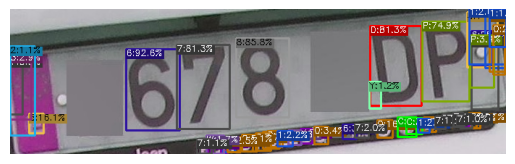

In [8]:
image_path = "/content/character-detection-datasets/data/test_00038_0.jpg"
outputs, img_info = predictor.inference(image_path)
result_image = predictor.visual(outputs[0], img_info, predictor.confthre)

plt.figure()
plt.imshow(result_image[..., ::-1])
_ = plt.axis("off")

2025-02-15 00:29:14 | INFO     | __main__:46 - Infer time: 0.0562s


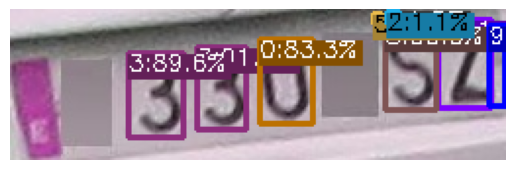

In [9]:
image_path = "/content/character-detection-datasets/data/test_00038_1.jpg"
outputs, img_info = predictor.inference(image_path)
result_image = predictor.visual(outputs[0], img_info, predictor.confthre)

plt.figure()
plt.imshow(result_image[..., ::-1])
_ = plt.axis("off")